
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

BUT RIGHT NOW I'VE GOT A BUG SOMEWHERE: balance !=0 doesn't work when num_files > 1. I've got an index problem.

So you can run with multiple variables files only when balance=0, or you can run with only one variable file and set balance how you like.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load libraries
# %pip install mlxtend

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
%matplotlib inline
start_time = dt.datetime.now()

In [4]:
import time

In [5]:
# set some parameters
num_files = 1
num_filter = 100
num_wrapper = 30
# keep balance = 0 when num_files > 1 until I figure out this bug. Maybe somebody else can figure it out.
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [ ]:
# path = "/content/drive/MyDrive/variables.csv"

In [ ]:
# start = time.time()
# #read data in chunks of 100000 rows at a time
# chunk = pd.read_csv(path,chunksize=500000)
# end = time.time()
# print("Read csv with chunks: ",(end-start),"sec")
# df = pd.concat(chunk)

Read csv with chunks:  0.02022266387939453 sec


In [ ]:
file_name = 'vars.csv'
df = pd.read_csv(file_name)

In [ ]:
%%time
for i in range(num_files):
    print('work on file ', file_name)
    df = df[df[index_name] <= 833508] # remove the last two months as the out-of-time data (OOT)
    df = df[df[index_name] >= 38512] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods.set_index(index_name, inplace=True)
            goods.sort_index(inplace=True)
            goods = goods.iloc[goods_keep] # THERE'S SOMETHING WRONG HERE AND I CAN'T FIGURE IT OUT
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.set_index(index_name, inplace=True)
    df_sampled.sort_index(inplace=True)
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
        filter_score.columns = ['variable','score']   
        j = 0
        for column in df_sampled:
            filter_score.loc[j,'variable'] = column
            filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
            j = j+1
            
        filter_score.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(filter_score['variable'][1:num_filter+1])
        print(filter_score.head(num_filter))
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        new = pd.DataFrame(np.zeros((num_vars+1,2)))
        new.columns = ['variable','score']   
        j = 0
        for column in df_sampled:
            new.loc[j,'variable'] = column
            new.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
            j = j+1
        
        new.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(new['variable'][1:num_filter+1])
        print(new.head(num_filter))
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
        filter_score = pd.concat([filter_score,new])
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()

work on file  vars.csv
                          variable     score
9                      fraud_label  1.000000
65           fulladdress_day_since  0.265731
37               address_day_since  0.263605
71            fulladdress_count_30  0.262755
43                address_count_30  0.260629
..                             ...       ...
17                 fulladdress_dob  0.065476
13                     fulladdress  0.065476
18           fulladdress_homephone  0.065476
101  fulladdress_homephone_count_0  0.065051
20              homephone_name_dob  0.064201

[200 rows x 2 columns]
CPU times: user 12.9 s, sys: 647 ms, total: 13.5 s
Wall time: 12.8 s


In [ ]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [ ]:
filter_score.head(30)

,variable,score
9,fraud_label,1.000000
65,fulladdress_day_since,0.267937
37,address_day_since,0.265546
71,fulladdress_count_30,0.264873
43,address_count_30,0.262232
70,fulladdress_count_14,0.258286
42,address_count_14,0.256397
69,fulladdress_count_7,0.248697
41,address_count_7,0.247246
177,ssn_name_dob_day_since,0.240240


In [ ]:
filter_score.tail(10)

,variable,score
81,name_fulladdress_count_1,0.004464
115,homephone_name_dob_count_0,0.000375
108,dob_homephone_count_0,0.000350
157,ssn_homephone_count_0,0.000337
94,fulladdress_dob_count_0,0.000337
136,ssn_address_count_0,0.000312
171,ssn_fulladdress_count_0,0.000312
87,name_homephone_count_0,0.000312
143,ssn_zip5_count_0,0.000300
80,name_fulladdress_count_0,0.000287


In [ ]:
filter_score.shape

(361, 2)

In [ ]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['fulladdress_day_since', 'address_day_since', 'fulladdress_count_30', 'address_count_30', 'fulladdress_count_14', 'address_count_14', 'fulladdress_count_7', 'address_count_7', 'ssn_name_dob_day_since', 'ssn_dob_day_since', 'name_dob_day_since', 'ssn_name_dob_count_30', 'ssn_dob_count_30', 'name_dob_count_30', 'ssn_name_day_since', 'ssn_firstname_day_since', 'ssn_lastname_day_since', 'ssn_day_since', 'ssn_name_count_30', 'ssn_firstname_count_30', 'ssn_lastname_count_30', 'ssn_count_30', 'fulladdress_count_0_by_30', 'address_count_0_by_30', 'name_dob_count_14', 'ssn_name_dob_count_14', 'ssn_dob_count_14', 'address_count_3', 'fulladdress_count_3', 'ssn_name_count_14', 'ssn_firstname_count_14', 'fulladdress_count_0_by_14', 'ssn_lastname_count_14', 'ssn_count_14', 'ssn_name_dob_count_0_by_30', 'ssn_dob_count_0_by_30', 'name_dob_count_0_by_30', 'address_count_0_by_14', 'ssn_name_count_0_by_30', 'ssn_firstname_count_0_by_30', 'ssn_lastname_count_0_by_30', 'ssn_count_0_by_30', '

In [ ]:
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,fulladdress_day_since,address_day_since,fulladdress_count_30,address_count_30,fulladdress_count_14,address_count_14,fulladdress_count_7,address_count_7,ssn_name_dob_day_since,ssn_dob_day_since,name_dob_day_since,ssn_name_dob_count_30,ssn_dob_count_30,name_dob_count_30,ssn_name_day_since,ssn_firstname_day_since,ssn_lastname_day_since,ssn_day_since,ssn_name_count_30,ssn_firstname_count_30,ssn_lastname_count_30,ssn_count_30,fulladdress_count_0_by_30,address_count_0_by_30,name_dob_count_14,ssn_name_dob_count_14,ssn_dob_count_14,address_count_3,fulladdress_count_3,ssn_name_count_14,ssn_firstname_count_14,fulladdress_count_0_by_14,ssn_lastname_count_14,ssn_count_14,ssn_name_dob_count_0_by_30,ssn_dob_count_0_by_30,name_dob_count_0_by_30,address_count_0_by_14,ssn_name_count_0_by_30,ssn_firstname_count_0_by_30,...,ssn_firstname_count_1_by_30,ssn_lastname_count_1_by_30,ssn_count_1_by_30,name_dob_count_1_by_14,address_count_1_by_7,ssn_name_dob_count_1_by_14,ssn_dob_count_1_by_14,ssn_name_count_1_by_14,ssn_firstname_count_1_by_14,ssn_lastname_count_1_by_14,ssn_dob_count_1,ssn_name_dob_count_1,name_dob_count_1,ssn_firstname_count_1,ssn_lastname_count_1,ssn_name_count_1,ssn_count_1,ssn_count_1_by_14,homephone_count_3,name_count_1,homephone_count_30,homephone_day_since,homephone_count_1,dob_count_1_by_7,ssn_name_dob_count_1_by_7,ssn_dob_count_1_by_7,name_dob_count_1_by_7,dob_count_1,ssn_name_count_1_by_7,ssn_firstname_count_1_by_7,ssn_lastname_count_1_by_7,ssn_count_1_by_7,fulladdress_homephone_day_since,name_count_1_by_30,fulladdress_homephone_count_30,name_count_1_by_14,address_count_0,fulladdress_count_0,dob_count_0_by_14,name_count_1_by_7
record,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38512,365.0,365.0,1,1,1,1,1,1,365.0,365.0,365.0,1,1,1,365.0,365.0,365.0,365.0,1,1,1,1,30.0,30.0,1,1,1,1,1,1,1,14.0,1,1,30.0,30.0,30.0,14.0,30.0,30.0,...,30.0,30.0,30.0,14.0,7.0,14.0,14.0,14.0,14.0,14.0,1,1,1,1,1,1,1,14.0,1,1,4,4.0,1,7.0,7.0,7.0,7.0,1,7.0,7.0,7.0,7.0,365.0,30.0,1,14.0,1,1,14.0,7.0
38513,365.0,365.0,1,1,1,1,1,1,365.0,365.0,365.0,1,1,1,365.0,365.0,365.0,365.0,1,1,1,1,30.0,30.0,1,1,1,1,1,1,1,14.0,1,1,30.0,30.0,30.0,14.0,30.0,30.0,...,30.0,30.0,30.0,14.0,7.0,14.0,14.0,14.0,14.0,14.0,1,1,1,1,1,1,1,14.0,2,1,6,1.0,2,3.5,7.0,7.0,7.0,1,7.0,7.0,7.0,7.0,365.0,30.0,1,14.0,1,1,7.0,7.0
38514,365.0,365.0,1,1,1,1,1,1,365.0,365.0,365.0,1,1,1,365.0,365.0,365.0,365.0,1,1,1,1,30.0,30.0,1,1,1,1,1,1,1,14.0,1,1,30.0,30.0,30.0,14.0,30.0,30.0,...,30.0,30.0,30.0,14.0,7.0,14.0,14.0,14.0,14.0,14.0,1,1,1,1,1,1,1,14.0,1,1,2,9.0,1,7.0,7.0,7.0,7.0,1,7.0,7.0,7.0,7.0,365.0,30.0,1,14.0,1,1,7.0,7.0
38515,365.0,365.0,1,1,1,1,1,1,365.0,365.0,365.0,1,1,1,365.0,365.0,365.0,365.0,1,1,1,1,30.0,30.0,1,1,1,1,1,1,1,14.0,1,1,30.0,30.0,30.0,14.0,30.0,30.0,...,30.0,30.0,30.0,14.0,7.0,14.0,14.0,14.0,14.0,14.0,1,1,1,1,1,1,1,14.0,1,1,1,365.0,1,7.0,7.0,7.0,7.0,1,7.0,7.0,7.0,7.0,365.0,30.0,1,14.0,1,1,14.0,7.0
38516,365.0,365.0,1,1,1,1,1,1,365.0,365.0,365.0,1,1,1,365.0,365.0,365.0,365.0,1,1,1,1,30.0,30.0,1,1,1,1,1,1,1,14.0,1,1,30.0,30.0,30.0,14.0,30.0,30.0,...,30.0,30.0,30.0,14.0,7.0,14.0,14.0,14.0,14.0,14.0,1,1,1,1,1,1,1,14.0,1,1,1,365.0,1,7.0,7.0,7.0,7.0,1,7.0,7.0,7.0,7.0,365.0,30.0,1,14.0,1,1,14.0,7.0


In [ ]:
df_keep.shape

(81120, 150)

In [ ]:
Y.head()

,fraud_label
record,
38512,0
38513,0
38514,0
38515,0
38516,0


In [ ]:
Y = Y.values
X = df_keep

In [ ]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:03:11.852018


In [ ]:
print(X.shape,Y.shape)

(81120, 150) (81120, 1)


In [ ]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

# Wrapper

In [6]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [ ]:
# Import the X, Y from the result of the jupyter notebook

In [7]:
X=pd.read_csv('X.csv')

In [8]:
X.shape

(794997, 100)

In [9]:
Y = np.load('Y.npy')

In [10]:
Y[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [11]:
Y.shape

(794997, 1)

In [12]:
%%time
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5,n_jobs=1) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=2,n_jobs=1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConv

CPU times: user 5h 41min 25s, sys: 2min 12s, total: 5h 43min 37s
Wall time: 5h 43min 13s


[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed: 12.6min finished

[2022-03-03 00:26:45] Features: 30/30 -- score: 0.5589413198676649

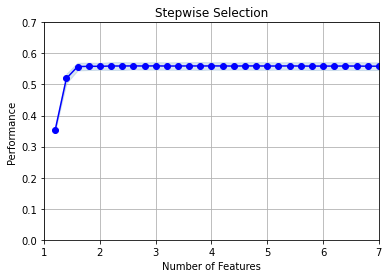

In [13]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev')
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.ylim([0., .7])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [14]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.351732543966568, 0.3567821695977712]",0.354257,"(fulladdress_count_30,)",0.010863,0.002525,0.002525
2,"(3, 27)","[0.5040919380114922, 0.5349120668640084]",0.519502,"(fulladdress_count_30, ssn_count_30)",0.066304,0.01541,0.01541
3,"(3, 27, 60)","[0.5450113181264148, 0.5699111962388995]",0.557461,"(fulladdress_count_30, ssn_count_30, homephone...",0.053568,0.01245,0.01245
4,"(3, 21, 27, 60)","[0.5465784433223054, 0.5706076963259621]",0.558593,"(fulladdress_count_30, fulladdress_homephone_c...",0.051695,0.012015,0.012015
5,"(2, 3, 21, 27, 60)","[0.5472749434093679, 0.5697370712171339]",0.558506,"(address_count_30, fulladdress_count_30, fulla...",0.048323,0.011231,0.011231
6,"(2, 3, 21, 25, 27, 60)","[0.5469266933658367, 0.5720006965000871]",0.559464,"(address_count_30, fulladdress_count_30, fulla...",0.053942,0.012537,0.012537
7,"(2, 3, 21, 25, 27, 60, 95)","[0.5469266933658367, 0.5721748215218527]",0.559551,"(address_count_30, fulladdress_count_30, fulla...",0.054317,0.012624,0.012624
8,"(2, 3, 21, 25, 27, 60, 63, 95)","[0.5483196935399617, 0.5713041964130245]",0.559812,"(address_count_30, fulladdress_count_30, fulla...",0.049447,0.011492,0.011492
9,"(2, 3, 21, 23, 25, 27, 60, 63, 95)","[0.5477973184746648, 0.5713041964130245]",0.559551,"(address_count_30, fulladdress_count_30, fulla...",0.050571,0.011753,0.011753
10,"(2, 3, 21, 23, 25, 27, 45, 60, 63, 95)","[0.5477973184746648, 0.5720006965000871]",0.559899,"(address_count_30, fulladdress_count_30, fulla...",0.052069,0.012102,0.012102


In [15]:
vars_final = list(vars_FS.loc[num_wrapper, 'feature_names'])
vars_final

['address_count_30',
 'fulladdress_count_30',
 'fulladdress_homephone_count_30',
 'ssn_dob_count_30',
 'name_dob_count_30',
 'ssn_count_30',
 'ssn_firstname_count_30',
 'ssn_name_count_30',
 'name_dob_count_14',
 'ssn_count_14',
 'ssn_name_dob_count_14',
 'ssn_lastname_count_14',
 'ssn_name_count_14',
 'ssn_dob_count_0_by_30',
 'name_dob_count_0_by_30',
 'ssn_count_0_by_30',
 'ssn_name_dob_count_0_by_30',
 'homephone_count_3',
 'name_dob_count_0_by_14',
 'ssn_dob_count_0_by_14',
 'ssn_count_7',
 'ssn_name_dob_count_0_by_14',
 'ssn_name_count_7',
 'fulladdress_homephone_count_3',
 'ssn_count_3',
 'ssn_firstname_count_3',
 'ssn_dob_count_3',
 'ssn_name_count_3',
 'ssn_lastname_count_3',
 'ssn_name_dob_count_3']

In [16]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/VarsFS.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  vars_FS.to_csv(f, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
sfs.subsets_

{1: {'avg_score': 0.35425735678216963,
  'cv_scores': array([0.35173254, 0.35678217]),
  'feature_idx': (3,),
  'feature_names': ('fulladdress_count_30',)},
 2: {'avg_score': 0.5195020024377504,
  'cv_scores': array([0.50409194, 0.53491207]),
  'feature_idx': (3, 27),
  'feature_names': ('fulladdress_count_30', 'ssn_count_30')},
 3: {'avg_score': 0.5574612571826572,
  'cv_scores': array([0.54501132, 0.5699112 ]),
  'feature_idx': (3, 27, 60),
  'feature_names': ('fulladdress_count_30',
   'ssn_count_30',
   'homephone_count_3')},
 4: {'avg_score': 0.5585930698241337,
  'cv_scores': array([0.54657844, 0.5706077 ]),
  'feature_idx': (3, 21, 27, 60),
  'feature_names': ('fulladdress_count_30',
   'fulladdress_homephone_count_30',
   'ssn_count_30',
   'homephone_count_3')},
 5: {'avg_score': 0.5585060073132508,
  'cv_scores': array([0.54727494, 0.56973707]),
  'feature_idx': (2, 3, 21, 27, 60),
  'feature_names': ('address_count_30',
   'fulladdress_count_30',
   'fulladdress_homephone_co

In [18]:
vars_final.append('index_name')
vars_final.append('y_name')
vars_final

['address_count_30',
 'fulladdress_count_30',
 'fulladdress_homephone_count_30',
 'ssn_dob_count_30',
 'name_dob_count_30',
 'ssn_count_30',
 'ssn_firstname_count_30',
 'ssn_name_count_30',
 'name_dob_count_14',
 'ssn_count_14',
 'ssn_name_dob_count_14',
 'ssn_lastname_count_14',
 'ssn_name_count_14',
 'ssn_dob_count_0_by_30',
 'name_dob_count_0_by_30',
 'ssn_count_0_by_30',
 'ssn_name_dob_count_0_by_30',
 'homephone_count_3',
 'name_dob_count_0_by_14',
 'ssn_dob_count_0_by_14',
 'ssn_count_7',
 'ssn_name_dob_count_0_by_14',
 'ssn_name_count_7',
 'fulladdress_homephone_count_3',
 'ssn_count_3',
 'ssn_firstname_count_3',
 'ssn_dob_count_3',
 'ssn_name_count_3',
 'ssn_lastname_count_3',
 'ssn_name_dob_count_3',
 'index_name',
 'y_name']

In [19]:
vars_final=['address_count_30',
 'fulladdress_count_30',
 'fulladdress_homephone_count_30',
 'ssn_dob_count_30',
 'ssn_count_30',
 'ssn_firstname_count_30',
 'ssn_lastname_count_30',
 'ssn_name_count_30',
 'ssn_count_14',
 'ssn_firstname_count_14',
 'ssn_lastname_count_14',
 'ssn_dob_count_0_by_30',
 'name_dob_count_0_by_30',
 'ssn_name_dob_count_0_by_30',
 'ssn_firstname_count_0_by_30',
 'fulladdress_homephone_count_0_by_30',
 'homephone_count_3',
 'name_dob_count_0_by_14',
 'ssn_dob_count_0_by_14',
 'name_dob_count_7',
 'ssn_count_0_by_14',
 'ssn_dob_count_7',
 'ssn_lastname_count_0_by_14',
 'fulladdress_homephone_count_0_by_14',
 'ssn_name_dob_count_7',
 'ssn_name_count_0_by_14',
 'name_dob_count_3',
 'ssn_name_count_3',
 'ssn_lastname_count_3',
 'ssn_name_dob_count_3',
 'index_name',
 'y_name']

In [20]:
df_keep=pd.read_csv('X.csv')

In [21]:
X_final = df_keep.filter(vars_final, axis=1)
X_final.shape

(794997, 30)

In [22]:
X_final.to_csv('vars_final.csv', index=False)

In [23]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 5:56:32.394445


In [30]:
set(vars_FS['feature_names'][15])-set(vars_FS['feature_names'][14])

{'name_dob_count_0_by_30'}

In [31]:
def get_diff(i):
  return set(vars_FS['feature_names'][i])-set(vars_FS['feature_names'][i-1])

In [54]:
get_diff(30)

{'ssn_name_count_7'}

In [24]:
import multiprocessing

multiprocessing.cpu_count()

2

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/vars_final.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  X_final.to_csv(f)

Mounted at /content/drive
